# Part C: Using a DNN to Estimate Area Of Future Fires


In [155]:
import pandas as pd

bushfires_df = pd.read_csv("../data/data.csv", index_col=0)
bushfires_df['acq_date'] = pd.to_datetime(bushfires_df['acq_date'])

bushfires_df

,Unnamed: 0,acq_date,fires,frp,scan,brightness,max_t_syd,max_t_bne,soi
0,0.0,2000-11-01,104.0,17572.6,195.4,357.982692,22.8,27.0,22.4
1,1.0,2000-11-02,211.0,45603.4,307.3,351.112322,22.3,24.0,22.4
2,2.0,2000-11-03,181.0,27439.3,325.8,353.117680,23.8,26.0,22.4
3,3.0,2000-11-04,239.0,29887.1,299.7,361.599163,23.0,28.0,22.4
4,4.0,2000-11-05,43.0,7193.7,92.0,347.181395,21.4,28.0,22.4
...,...,...,...,...,...,...,...,...,...
6830,6919.0,2019-10-12,211.0,36282.4,312.8,361.617062,20.4,21.3,-5.6
6831,6920.0,2019-10-13,128.0,23654.4,225.6,357.284375,19.2,25.3,-5.6
6832,6921.0,2019-10-14,230.0,49021.2,346.0,361.449565,21.9,25.9,-5.6
6833,6922.0,2019-10-15,137.0,23865.6,232.1,357.659854,24.0,27.2,-5.6


In [156]:
# Feature engineering to introduce seasonality concepts and trends.
import numpy as np

bushfires_df["time_sin"] = np.sin((bushfires_df['acq_date'].dt.day_of_year / 365) * 2 * np.pi)
bushfires_df["time_cos"] = np.cos((bushfires_df['acq_date'].dt.day_of_year / 365) * 2 * np.pi)
bushfires_df["year"] = bushfires_df['acq_date'].dt.year

In [157]:
df = pd.DataFrame()

df['acq_date'] = bushfires_df['acq_date']
df['scan'] = bushfires_df['scan']
df['max_t_syd'] = bushfires_df['max_t_syd']
df['max_t_bne'] = bushfires_df['max_t_bne']
df['time_sin'] = bushfires_df['time_sin']
df['time_cos'] = bushfires_df['time_cos']
df['soi'] = bushfires_df['soi']
df['year'] = bushfires_df['year']

df = df.dropna()

In [158]:
# Preview what sort of data is in here.
df = df.sort_values(["scan"])

df

,acq_date,scan,max_t_syd,max_t_bne,time_sin,time_cos,soi,year
3478,2010-07-06,1.0,17.2,22.5,-0.077386,-0.997001,20.5,2010
2628,2008-02-28,1.0,21.4,29.5,0.849817,0.527078,21.3,2008
5499,2016-01-31,1.0,31.1,34.0,0.508671,0.860961,-19.7,2016
5505,2016-02-06,1.0,27.0,29.9,0.594727,0.803928,-19.7,2016
1158,2004-02-05,1.0,26.4,27.9,0.580800,0.814046,9.1,2004
...,...,...,...,...,...,...,...,...
4310,2012-10-20,3719.3,33.8,30.2,-0.939856,0.341571,2.4,2012
4313,2012-10-23,4687.7,19.5,24.8,-0.920971,0.389630,2.4,2012
697,2002-11-01,4722.2,24.5,30.0,-0.858764,0.512371,-6.0,2002
4312,2012-10-22,5576.4,18.7,33.2,-0.927542,0.373720,2.4,2012


In [159]:
# drop acq_date - it isn't required for the model.
df = df.drop(columns=['acq_date'])
df = df.sort_index()

df

,scan,max_t_syd,max_t_bne,time_sin,time_cos,soi,year
0,195.4,22.8,27.0,-0.849817,0.527078,22.4,2000
1,307.3,22.3,24.0,-0.840618,0.541628,22.4,2000
2,325.8,23.8,26.0,-0.831171,0.556017,22.4,2000
3,299.7,23.0,28.0,-0.821477,0.570242,22.4,2000
4,92.0,21.4,28.0,-0.811539,0.584298,22.4,2000
...,...,...,...,...,...,...,...
6830,312.8,20.4,21.3,-0.981306,0.192452,-5.6,2019
6831,225.6,19.2,25.3,-0.977848,0.209315,-5.6,2019
6832,346.0,21.9,25.9,-0.974100,0.226116,-5.6,2019
6833,232.1,24.0,27.2,-0.970064,0.242850,-5.6,2019


In [160]:
df.describe()

,scan,max_t_syd,max_t_bne,time_sin,time_cos,soi,year
count,6835.000000,6835.000000,6835.000000,6835.000000,6835.000000,6835.000000,6835.000000
mean,205.932729,23.098654,26.631207,-0.003094,0.000129,0.016913,2009.833504
std,337.232707,4.455929,3.796224,0.706831,0.707479,9.994913,5.462412
min,1.000000,11.700000,12.600000,-0.999991,-0.999963,-28.600000,2000.000000
25%,35.800000,19.800000,23.800000,-0.705584,-0.708627,-7.000000,2005.000000
50%,84.900000,23.000000,26.900000,-0.008607,-0.012910,-1.100000,2010.000000
75%,225.400000,26.000000,29.300000,0.705584,0.714673,7.300000,2015.000000
max,5854.700000,45.800000,41.700000,0.999991,1.000000,27.100000,2019.000000


In [161]:
# Split into train/test

train_dataset = df.sample(frac=0.8, random_state=0)
test_dataset = df.drop(train_dataset.index)

In [162]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('scan')
test_labels = test_features.pop('scan')

In [163]:
import tensorflow as tf

# Disable GPU. GPU makes this particular model slower.
tf.config.set_visible_devices([], 'GPU')

In [164]:
normalizer = tf.keras.layers.Normalization(axis=-1) # update this if data changes.
normalizer.adapt(np.array(train_features))

In [165]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.6,
                              patience=1, min_delta=-1, min_lr=0.00000000001, verbose=1, mode="min")

In [166]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, verbose=1, min_delta=1)

In [167]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="./checkpoints/checkpoint",
    save_weights_only=True,
    monitor="val_loss",
    mode="min",
    save_best_only=True,
)

In [168]:
# Custom loss to punish undershooting. Based on mean_squared_error.
def custom_loss(y_true, y_pred):
    error = y_true - y_pred
    squared_error = tf.square(error)
    undershoot_error = tf.square(tf.math.maximum(0.0, error)) / 2 # undershooting is 1.5x as bad as overshooting.
    return tf.reduce_mean(squared_error + undershoot_error, axis=-1)

In [169]:
# Utility function for the model
def build_and_compile_model():
    model = tf.keras.Sequential()
    
    model.add(normalizer)

    for i in range(5):
        model.add(tf.keras.layers.Dense(40, activation="relu"))
        
    model.add(tf.keras.layers.Dense(1, activation="relu"))

    model.compile(loss=custom_loss, metrics=["mean_absolute_error"], optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
    return model

In [170]:
model = build_and_compile_model()

In [171]:
history = model.fit(
    train_features,
    train_labels,
    validation_data=(test_features, test_labels),
    verbose=1, epochs=500, callbacks=[early_stopping, model_checkpoint_callback])

Epoch 1/500
171/171 [==============================] - 0s 1ms/step - loss: 181347.5000 - mean_absolute_error: 191.0413 - val_loss: 106210.4922 - val_mean_absolute_error: 166.1137
Epoch 2/500
171/171 [==============================] - 0s 914us/step - loss: 117323.4375 - mean_absolute_error: 167.7208 - val_loss: 101831.4453 - val_mean_absolute_error: 135.3648
Epoch 3/500
171/171 [==============================] - 0s 935us/step - loss: 112955.2734 - mean_absolute_error: 157.0862 - val_loss: 93122.3906 - val_mean_absolute_error: 145.2824
Epoch 4/500
171/171 [==============================] - 0s 917us/step - loss: 108296.7656 - mean_absolute_error: 154.4981 - val_loss: 90872.6484 - val_mean_absolute_error: 131.8623
Epoch 5/500
171/171 [==============================] - 0s 956us/step - loss: 104518.6094 - mean_absolute_error: 150.9680 - val_loss: 86008.1719 - val_mean_absolute_error: 135.1582
Epoch 6/500
171/171 [==============================] - 0s 842us/step - loss: 101209.1094 - mean_abso

In [172]:
# Utility function for plotting loss
import matplotlib.pyplot as plt

def plot_loss(history):
    plt.plot(history.history['mean_absolute_error'], label='loss')
    plt.plot(history.history['val_mean_absolute_error'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)

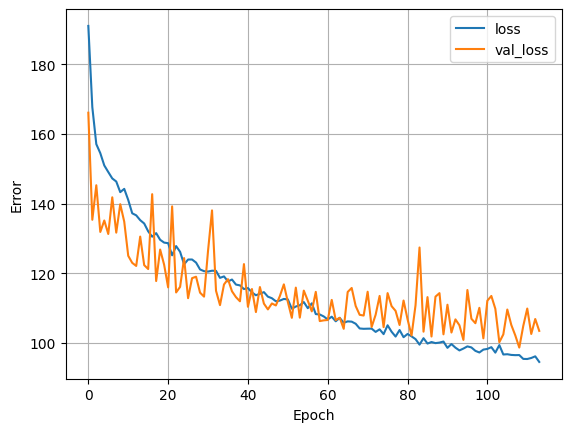

In [173]:
plot_loss(history)

In [174]:
# Load best checkpoints
model.load_weights("./checkpoints/checkpoint")

43/43 [==============================] - 0s 420us/step


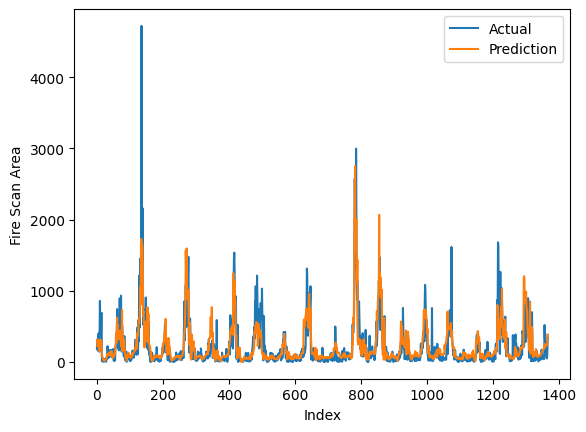

In [175]:
plt.plot(test_labels.reset_index()['scan'], label="Actual")
plt.plot(model.predict(test_features), label="Prediction")
plt.xlabel("Index")
plt.ylabel("Fire Scan Area")
plt.legend()

In [176]:
model.export("../model")
print(model.count_params())

model

INFO:tensorflow:Assets written to: ../model/assets


INFO:tensorflow:Assets written to: ../model/assets


Saved artifact at '../model'. The following endpoints are available:

* Endpoint 'serve'
  Args:
    args_0: float32 Tensor, shape=(None, None)
  Returns:
    float32 Tensor, shape=(None, 1)
6894


Testing to see if loading models works.

In [177]:
loaded_model = tf.saved_model.load("../model")

predictions = loaded_model.serve(test_features)

predictions

<tf.Tensor: shape=(1367, 1), dtype=float32, numpy=
array([[305.23456],
       [252.86937],
       [219.03986],
       ...,
       [248.9198 ],
       [358.1183 ],
       [384.47333]], dtype=float32)>

In [178]:
test_features

,max_t_syd,max_t_bne,time_sin,time_cos,soi,year
0,22.8,27.0,-0.849817,0.527078,22.4,2000
7,21.9,25.0,-0.780296,0.625411,22.4,2000
21,23.8,26.0,-0.608477,0.793572,22.4,2000
24,25.3,27.0,-0.566702,0.823923,22.4,2000
25,26.3,28.0,-0.552435,0.833556,22.4,2000
...,...,...,...,...,...,...
6812,20.7,24.9,-0.993257,-0.115935,-12.4,2019
6814,20.8,25.8,-0.996659,-0.081676,-12.4,2019
6815,25.3,26.9,-0.997917,-0.064508,-12.4,2019
6821,29.3,25.9,-0.999250,0.038722,-5.6,2019


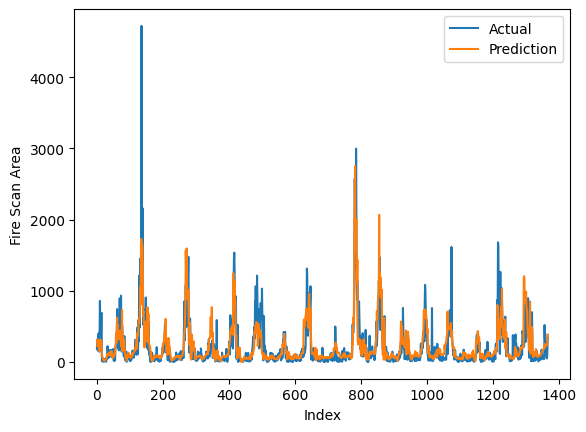

In [179]:
plt.plot(test_labels.reset_index()['scan'], label="Actual")
plt.plot(predictions, label="Prediction")
plt.xlabel("Index")
plt.ylabel("Fire Scan Area")
plt.legend()